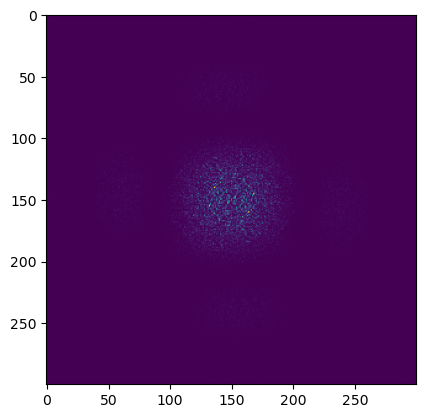

In [2]:
import torch
import matplotlib.pyplot as plt

from source import I, gridMA

K = torch.full((5,5), .4)
K[3,3] = 1

sampler = gridMA(K)

plt.imshow(I(sampler(300, 300)[0][0]))

In [ ]:
from scipy.stats import norm

# defining T3
def T3_eq(x, y):
  n = torch.prod(torch.tensor(x.shape))
  G_s = (I(x) - I(y))/ (I(x) + I(y))
  return torch.mean(G_s) * torch.sqrt(3 * n)

ALPHA = .05

# does it hold the size?
results = torch.full((200, 1), 0)
for i in range(200):
  x = sampler(250, 250)
  y = sampler(250, 250)

  crit = norm.cdf(1-ALPHA /2)
  results[i] = 1 if torch.abs(T3_eq(x, y)) > crit else 0 

In [77]:
def _periodogram_rfftn(x: torch.Tensor, detrend=True, taper: torch.Tensor=None):
    x = x.float()
    if detrend:
        x = x - x.mean()
    if taper is not None:
        x = x * taper  # same shape as x
    F = torch.fft.rfftn(x, dim=(-2, -1))
    I = (F.abs() ** 2)  # common constants cancel in ratios
    return I

def T3_eq(x: torch.Tensor, y: torch.Tensor, detrend=True, taper: torch.Tensor=None, eps=1e-12):
    # periodograms on the same rfftn grid
    IA = _periodogram_rfftn(x, detrend=detrend, taper=taper)
    IB = _periodogram_rfftn(y, detrend=detrend, taper=taper)

    # build mask of frequencies to use: drop DC and Nyquist lines
    H, W_r = IA.shape  # rfftn gives shape (n1, n2//2+1)
    mask = torch.ones_like(IA, dtype=torch.bool)
    mask[0, 0] = False                      # remove ω1 = 0
    if H % 2 == 0: mask[H//2, :] = False    # remove Nyquist row if present
    if (W_r - 1) * 2 == x.shape[-1]:        # even n2 → Nyquist col exists at end
        mask[:, -1] = False

    IA_m = IA * mask
    IB_m = IB * mask

    denom = IA_m + IB_m
    Gs = (IA_m - IB_m) / (denom + eps)

    n_star = Gs.numel()
    T3 = Gs.mean() * torch.sqrt(torch.tensor(3.0 * n_star, dtype=Gs.dtype, device=Gs.device))
    return T3

ALPHA = .05

# does it hold the size?
N = 3000
results = torch.full((N, 1), 0)
crit = norm.ppf(1-ALPHA /2)
for i in range(N):
  x = sampler(300, 300)
  y = sampler(300, 300)
  results[i] = 1 if torch.abs(T3_eq(x[0][0], y[0][0])) > crit else 0

print(f"Size from MC: {results.sum()/ N} %")

Size from MC: 0.07433333247900009 %


In [76]:
T3_eq(x[0][0], y[0][0])

tensor(-0.7142)

In [78]:
# under alternative
K0 = torch.full((3,3),.7)
K0[1,1] = 1

sampler0 = gridMA(K0)

def blur_h1_gen(delta):
  K1 = torch.full((7,7), delta)
  K1[3:6, 3:6] = K0
  return gridMA(K1)

sampler1 = blur_h1_gen(.1)

ALPHA = .05

# does it hold the size?
N = 3000
results = torch.full((N, 1), 0)
crit = norm.ppf(1-ALPHA /2)
for i in range(N):
  x = sampler0(25, 25)
  y = sampler1(25, 25)
  results[i] = 1 if torch.abs(T3_eq(x[0][0], y[0][0])) > crit else 0

print(f"Power from MC under alpha={ALPHA}: {results.sum()/ N} %")

Power from MC under alpha=0.05: 0.42766666412353516 %


In [83]:
# we are going to abstract away most of the simulation code, such that we can focus on the alternative
def power_sim(sampler0, h1_generator, deltas, N = 200, grid_sizes = [20, 25, 30, 40, 50]):
    rejected = torch.zeros(5, 20)
    i = 0
    crit = norm.ppf(1-ALPHA /2)
    for grid_size in grid_sizes:
        phi_n_star_monte_carlo = torch.vmap(lambda x, y: torch.abs(T3_eq(x, y)),
                                    randomness="different")
        j = 0
        for delta in deltas:
            sampler1 = h1_generator(delta)
            x = sampler1(grid_size, grid_size, N)
            y = sampler0(grid_size, grid_size, N)
            decision = phi_n_star_monte_carlo(x[:, 0], y[:, 0]) > crit
            rejected[i, j] = decision.sum() / N
            j += 1
        i += 1
    return rejected

def plot_power_result(rejected, deltas, grid_sizes = [20, 25, 30, 40, 50]):
  plt.figure(dpi = 150)
  for i in range(rejected.shape[0]):
      plt.plot(deltas, rejected[i], label = f"{grid_sizes[i]} x {grid_sizes[i]}")
  plt.title("Power of Test für N = 200")
  plt.legend(title ="Lattice size")
  plt.ylabel("Estimated Power")
  plt.xlabel("delta")
  plt.show()

K0 = torch.full((3,3),.7)
K0[1,1] = 1

sampler0 = gridMA(K0)

def blur_h1_gen(delta):
  K1 = torch.full((7,7), delta)
  K1[3:6, 3:6] = K0
  return gridMA(K1)

deltas = torch.linspace(0, .9, 20)

rej_h1_ma_full = power_sim(sampler0, blur_h1_gen, deltas, 1000)

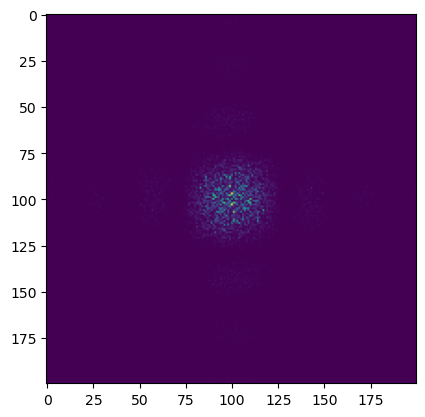

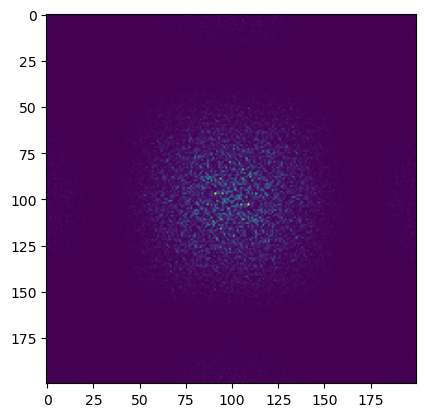

In [87]:
sampler0
sampler1 = blur_h1_gen(.5)

plt.imshow(I(sampler1(200, 200)[0][0]))
plt.show()
plt.imshow(I(sampler0(200, 200)[0][0]))
plt.show()

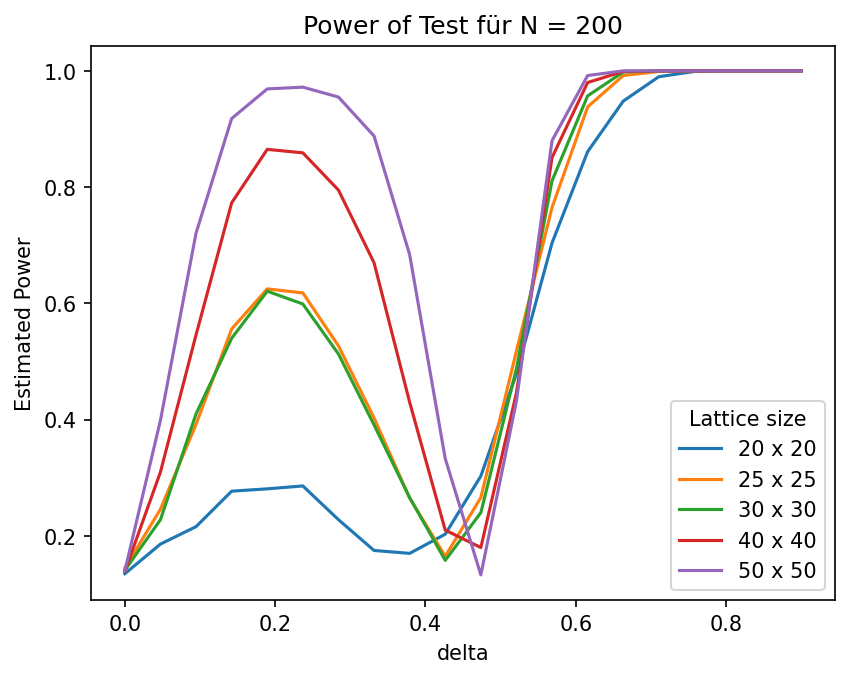

In [84]:
plot_power_result(rej_h1_ma_full, deltas)

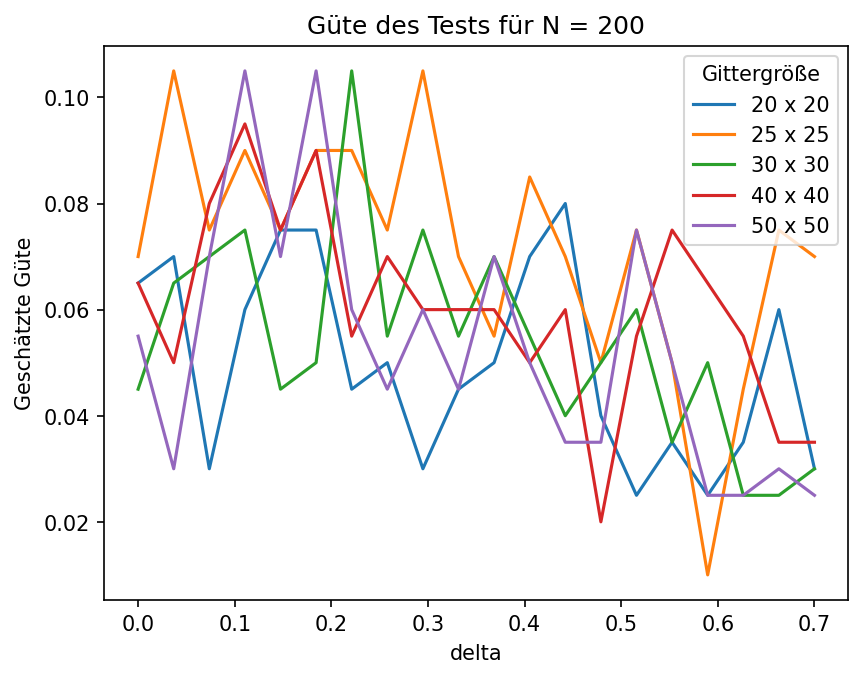

In [73]:
from source import PlaneSampler

def spin_gen(delta, diag = .03):
  sampler = PlaneSampler(40, .1 + delta, diag, 0.8-delta)
  return sampler

sampler_AR0 = spin_gen(0.0)

rej_h1_AR_spin = power_sim(sampler_AR0, spin_gen, deltas)
plot_power_result(rej_h1_AR_spin, deltas)